In [4]:
import numpy as np
from scipy.signal import fftconvolve

def circular_convolve_1d(x, h, method='fft', flip_kernel=True):
    """
    Perform circular convolution of 1D signal x with kernel h.

    Parameters:
    ----------
    x : np.ndarray
        Input signal (1D array).
    h : np.ndarray
        Convolution kernel (1D array).
    method : str
        'fft' or 'manual'
    flip_kernel : bool
        If True, flips the kernel to match intuitive alignment
        (i.e., h[-1] aligns with current sample).

    Returns:
    -------
    y : np.ndarray
        Circular convolution result, same size as x.
    """
    N = len(x)
    h = np.asarray(h)
    if flip_kernel:
        h = h[::-1]

    if method == 'manual':
        y = np.zeros_like(x, dtype=np.float64)
        for i in range(N):
            for k in range(len(h)):
                idx = (i - k) % N  # circular indexing
                y[i] += h[k] * x[idx]
        return y

    elif method == 'fft':
        # Zero-pad or wrap to size N
        h_padded = np.zeros_like(x)
        h_padded[:len(h)] = h
        y = np.fft.ifft(np.fft.fft(x) * np.fft.fft(h_padded)).real
        return y

    else:
        raise ValueError("Method must be 'manual' or 'fft'")


In [5]:
x = np.array([1, 2, 3, 4, 5])
h = np.array([2, 1])  # Will be flipped to [1, 2]

y_manual = circular_convolve_1d(x, h, method='manual')
y_fft    = circular_convolve_1d(x, h, method='fft')

print("Manual:", y_manual)
print("FFT   :", y_fft)


Manual: [11.  4.  7. 10. 13.]
FFT   : [11.  4.  7. 10. 13.]


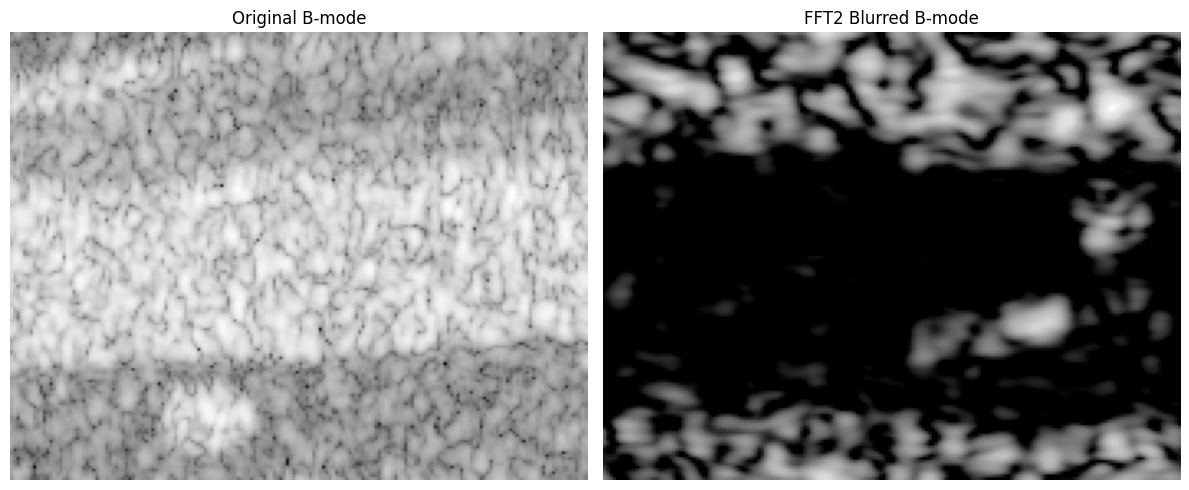

In [6]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from numpy.fft import fft2, ifft2, fftshift
from skimage.exposure import match_histograms

# -------------------------------------------
# 1. Circular Convolution Using FFT2
# -------------------------------------------
def fft_bccb_convolution(rf_img: np.ndarray, psf: np.ndarray) -> np.ndarray:
    H, W = rf_img.shape
    Mh, Mw = psf.shape
    pad_psf = np.zeros_like(rf_img)
    pad_psf[:Mh, :Mw] = psf
    pad_psf = fftshift(pad_psf)

    RF_F = fft2(rf_img)
    PSF_F = fft2(pad_psf)
    Y_F = RF_F * PSF_F
    return np.real(ifft2(Y_F))


# -------------------------------------------
# 2. RF to B-mode Conversion
# -------------------------------------------
def rf_to_bmode(rf: np.ndarray, reference_bmode=None, dyn_range_db=60) -> np.ndarray:
    env = np.abs(hilbert(rf, axis=0))
    bmode = 20 * np.log10(env + 1e-6)
    bmode = np.clip(bmode, -dyn_range_db, None)
    bmode -= bmode.min()
    bmode /= bmode.max()
    bmode *= 255.0
    bmode = np.uint8(bmode)

    if reference_bmode is not None:
        bmode = match_histograms(bmode, reference_bmode, channel_axis=None)
    return bmode


# -------------------------------------------
# 3. Load .mat Data (Vivo Dataset)
# -------------------------------------------
mat = scipy.io.loadmat("exp/datasets/anes_data/simu/1/data.mat")
rf = mat["rf"].astype(np.float32)
#psf = mat["PSF_ref"].astype(np.float32)
scipy.io.loadmat("exp/datasets/anes_data/simu/1/psf_GT_1.mat")

# -------------------------------------------
# 4. FFT2-Based Convolution and B-mode Creation
# -------------------------------------------
blurred_rf = fft_bccb_convolution(rf, psf)
bmode_orig = rf_to_bmode(rf)
bmode_blurred = rf_to_bmode(blurred_rf, reference_bmode=bmode_orig)

# -------------------------------------------
# 5. Display Comparison
# -------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(bmode_orig, cmap='gray', aspect='auto')
plt.title("Original B-mode")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bmode_blurred, cmap='gray', aspect='auto')
plt.title("FFT2 Blurred B-mode")
plt.axis('off')

plt.tight_layout()
plt.savefig("bmode_vivo_fft2.png", dpi=300)
plt.show()


In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift

def wiener_filter(y, h, SNR_dB, tau=None):
    """
    Perform Wiener deconvolution in the frequency domain.

    Parameters:
    -----------
    y : 2D ndarray
        Observed (blurred) image.
    h : 2D ndarray
        Point Spread Function (PSF).
    SNR_dB : float
        Signal-to-noise ratio in decibels.
    tau : float, optional
        Regularization parameter. If not provided, derived from SNR_dB.

    Returns:
    --------
    x_est : 2D ndarray
        Deblurred image.
    """
    # Convert SNR from dB to linear
    SNR_linear = 10**(SNR_dB / 10)

    # Get dimensions
    Mx, Nx = y.shape
    Mh, Nh = h.shape

    # Pad PSF to image size
    pad_h = np.zeros_like(y)
    pad_h[:Mh, :Nh] = h

    # Center the PSF using fftshift-like circshift
    center = (Mh // 2, Nh // 2)
    pad_h = np.roll(pad_h, shift=(-center[0], -center[1]), axis=(0,1))

    # FFT of PSF and image
    Hf = fft2(pad_h)
    Yf = fft2(y)

    # Regularization parameter
    if tau is None:
        tau = 1 / SNR_linear  # inverse since tau ~ noise / signal

    # Wiener deconvolution in frequency domain
    Hf_conj = np.conj(Hf)
    denominator = Hf_conj * Hf + tau
    Xf = (Hf_conj / denominator) * Yf

    # Inverse FFT and take real part
    x_est = np.real(ifft2(Xf))

    return x_est


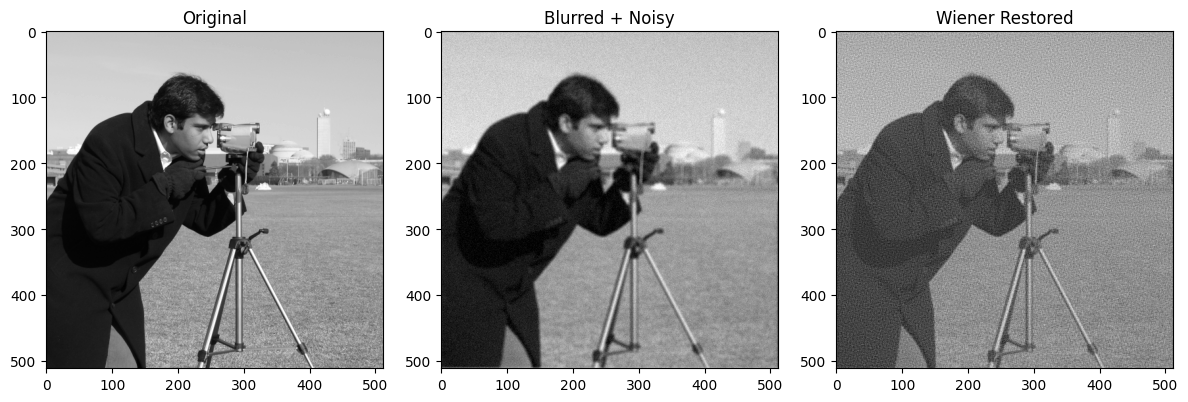

(None, None)

In [2]:
from skimage import data, img_as_float
from skimage.util import random_noise
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Example image and PSF
image = img_as_float(data.camera())
psf = np.ones((5, 5)) / 25  # Simple box blur
blurred = convolve2d(image, psf, mode='same', boundary='wrap')
noisy = random_noise(blurred, var=0.001)

# Wiener filter application
restored = wiener_filter(noisy, psf, SNR_dB=20)

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,3,1), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.subplot(1,3,2), plt.imshow(noisy, cmap='gray'), plt.title('Blurred + Noisy')
plt.subplot(1,3,3), plt.imshow(restored, cmap='gray'), plt.title('Wiener Restored')
plt.tight_layout(), plt.show()


In [3]:
import scipy.io

# Load the vivo data.mat file
vivo_mat_path = "exp/datasets/anes_data/vivo/data.mat"
vivo_data = scipy.io.loadmat(vivo_mat_path)

# Extract and display variable names and their shapes
vivo_summary = {key: value.shape for key, value in vivo_data.items() if not key.startswith("__")}
vivo_summary


{'PSF_estim': (21, 11), 'bmode': (401, 200), 'rf': (401, 200)}

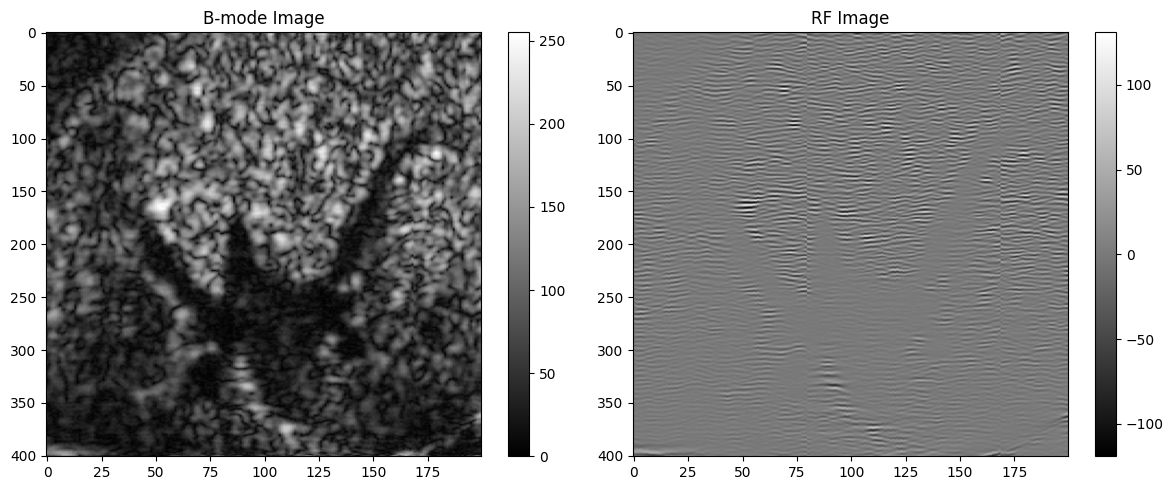

In [4]:
import matplotlib.pyplot as plt

# Extract data
bmode = vivo_data['bmode']
rf = vivo_data['rf']

# Plot B-mode and RF
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(bmode, cmap='gray', aspect='auto')
plt.title("B-mode Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(rf, cmap='gray', aspect='auto')
plt.title("RF Image")
plt.colorbar()

plt.tight_layout()
plt.show()


In [2]:
!python main_mat_vivo.py \
  --mat_dir exp/datasets/anes_data/vivo \
  --mat_list exp/datasets/anes_data/vivo/mat_list.txt \
  --key rf \
  --psf_path exp/datasets/anes_data/vivo/psf_estim_vivo.mat \
  --model_path exp/logs/imagenet/256x256_diffusion_uncond.pt \
  --timesteps 20 \
  --eta 0.85 \
  --etaB 1.0 \
  --deg deblur_bccb \
  --sigma_0 0 \
  --image_size 256 \
  --output_dir batch_results/vivo_ddrm \
  --config deblur_us.yml \
  --doc vivo


Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/MIRDDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO:root:Using device: cuda
INFO:root:Using device: cuda
INFO - main.py - 2025-05-13 11:32:30,386 - Using device: cuda
INFO:root:✅ Model instantiated and checkpoint loaded.
INFO - main_mat_vivo.py - 2025-05-13 11:32:36,353 - ✅ Model instantiated and checkpoint loaded.
INFO:root:Loading PSF from: exp/datasets/anes_data/vivo/psf_estim_vivo.mat
INFO - main_mat_vivo.py - 2025-05-13 11:32:36,354 - Loading PSF from

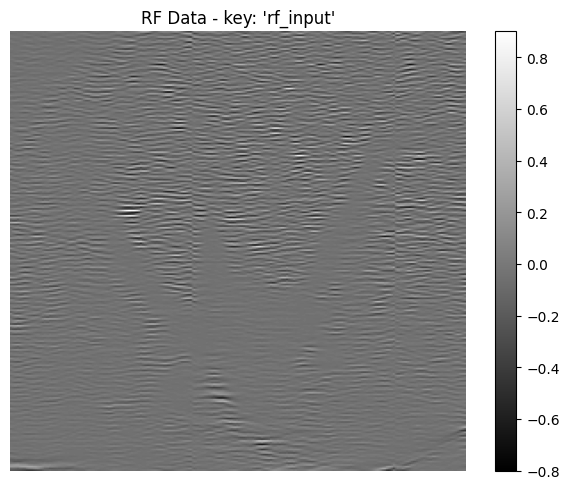

In [4]:
import scipy.io
import matplotlib.pyplot as plt

# Load the RF data from .mat file
mat_path = "batch_results/vivo_ddrm/degraded_rf.mat" # Replace with your actual file path
mat_data = scipy.io.loadmat(mat_path)

# Automatically find RF-like key
rf_key = next(k for k in mat_data if not k.startswith('__'))
rf = mat_data[rf_key]

# Display RF as grayscale image
plt.figure(figsize=(6, 5))
plt.imshow(rf, cmap='gray', aspect='auto')
plt.title(f"RF Data - key: '{rf_key}'")
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
!python main_mat_vivo.py \
  --mat_dir exp/datasets/anes_data/vivo \
  --mat_list exp/datasets/anes_data/vivo/mat_list.txt \
  --key rf \
  --psf_path exp/datasets/anes_data/vivo/psf_estim_vivo.mat \
  --model_path exp/logs/imagenet/256x256_diffusion_uncond.pt \
  --timesteps 20 50 100 \
  --eta 0.85 --etaB 1.0 --deg deblur_bccb --sigma_0 0 \
  --image_size 256 \
  --output_dir batch_results/vivo_compare \
  --config deblur_us.yml --doc vivo


Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/MIRDDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO:root:Using device: cuda
INFO:root:Using device: cuda
INFO - main.py - 2025-05-13 13:37:00,458 - Using device: cuda
INFO:root:✅ model checkpoint loaded
INFO - main_mat_vivo.py - 2025-05-13 13:37:06,308 - ✅ model checkpoint loaded
20it [00:13,  1.48it/s]
INFO:root:✅ saved batch_results/vivo_compare/restored_t20.mat
INFO - main_mat_vivo.py - 2025-05-13 13:37:19,943 - ✅ saved batch_results/vivo_compare/restor